In [1]:

import pandas as pd
# Load the two datasets
df1 = pd.read_csv('overlappingusers_Dep1922.csv')
df2 = pd.read_csv('overlappingusers_Sui1922.csv')

In [2]:
df1.shape

(84101, 5)

In [3]:
df2.shape

(70742, 7)

In [5]:
# Apply text preprocessing to the 'selftext' column
df1['cleanedtext'] = df1['selftext'].apply(clean_text)
# Apply text preprocessing to the 'selftext' column
df2['cleanedtext'] = df2['selftext'].apply(clean_text)

In [6]:
# Apply text preprocessing to the 'selftext' column
df1['title'] = df1['title'].apply(clean_text)
# Apply text preprocessing to the 'selftext' column
df2['title'] = df2['title'].apply(clean_text)

In [7]:
df1.to_csv('Cleaned_overlappingusers_Dep1922.csv')
df2.to_csv('Cleaned_overlappingusers_Sui1922.csv')

To add the "SI_User" feature to df1 based on the presence of suicide ideation posts in df2, you can follow these steps:

Create a set of unique authors from df2 who have at least one post with "suicideideation" label equal to 1.
Use the "isin" method to check if each author in df1 is present in the set of authors from step 1.
Assign 1 to the "SI_User" column in df1 for authors that are present in the set, and assign 0 for the rest.


In [ ]:

import pandas as pd
# Load the two datasets
df1 = pd.read_csv('Cleaned_overlappingusers_Dep1922.csv')
df2 = pd.read_csv('Cleaned_overlappingusers_Sui1922.csv')

In [4]:
# Step 1: Get the set of unique authors from df2 with suicide ideation label equal to 1
authors_with_suicide_ideation = set(df2.loc[df2['suicideIdeation'] == 1, 'author'])

# Step 2: Check if each author in df1 is present in the set
df1['SI_User'] = df1['author'].isin(authors_with_suicide_ideation).astype(int)


In [5]:
df1.head(3)

,author,created_utc,selftext,title,subreddit,SI_User
0,MiniBoiiii,2019-04-01 00:38:19,i deal with depression and anxiety and hate ta...,Why is school and work more important than my ...,depression,0
1,PhoenixStorm1015,2019-04-01 01:27:48,this is gonna be a bit long. consider yourself...,Saying no to meds a bad idea?,depression,1
2,SwixSwax,2019-04-01 01:42:20,sometimes i look back on my life and feel as i...,"I've Never Been Loved, Only Useful",depression,1


In [6]:
si_user_counts = df1['SI_User'].value_counts()
si_user_1_count = si_user_counts[1]
si_user_0_count = si_user_counts[0]


In [7]:
si_user_1_count

69430

In [8]:
si_user_0_count

14671

In [9]:
selected_df  = df1


In [10]:
selected_df .shape

(84101, 6)

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import contractions
def clean_text(text):
    # Replace missing values with empty strings
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    #fix the contraction 
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words with numbers
    text = re.sub(r'\b\w*\d+\w*\b', '', text)
    
    # Remove unusually long words
    text = re.sub(r'\b\w{20,}\b', '', text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Lowercase text
    tokens = [token.lower() for token in tokens]

    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stem words
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens into a string
    text = ' '.join(tokens)
    
    return(text)

In [12]:
# Apply text preprocessing to the 'selftext' column
selected_df['preprocessed_text'] = selected_df['selftext'].apply(clean_text)

In [13]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#Step 3: Train Word2Vec Model
from gensim.models import Word2Vec

# Tokenize the preprocessed text
tokenized_text = selected_df['preprocessed_text'].apply(word_tokenize)

In [14]:
# step 3 : Train the Word2Vec model
model = Word2Vec(tokenized_text, min_count=1)

In [15]:
#Step 4: Feature Extraction using Word Embeddings
import numpy as np

# Function to calculate the document embedding
def calculate_doc_embedding(text):
    embeddings = [model.wv[word] for word in word_tokenize(text) if word in model.wv]
    if embeddings:
        doc_embedding = np.mean(embeddings, axis=0)
        return doc_embedding
    return None

# Calculate document embeddings for the preprocessed text
selected_df['doc_embedding'] = selected_df['preprocessed_text'].apply(calculate_doc_embedding)

# Remove rows with missing document embeddings
selected_df = selected_df.dropna()


In [16]:
#method2 Convert text to document embeddings
document_embeddings = tokenized_text.apply(lambda tokens: np.mean([model.wv[word] for word in tokens], axis=0))

/home/jzhu10/.conda/envs/twitter/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [17]:
#Here's a step-by-step implementation of the factor analysis process, including the determination of the optimal number of factors:
from sklearn.decomposition import FactorAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert document embeddings to a numpy array
features = np.array(selected_df['doc_embedding'].tolist())

# Step 2: Determine the optimal number of factors
n_factors = range(1, 10)  # Specify the range of factor numbers to consider
explained_variances = []

for n in n_factors:
    fa = FactorAnalysis(n_components=n, random_state=42)
    fa.fit(features)
    noise_variance = np.mean(fa.noise_variance_)
    total_variance = np.sum(np.var(features, axis=0))
    explained_variance_ratio = 1 - (noise_variance / total_variance)
    explained_variances.append(explained_variance_ratio)

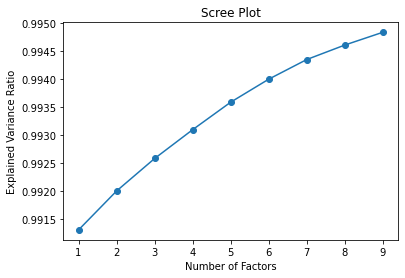

Optimal Number of Factors: 9


In [18]:
# Plot the scree plot to visualize explained variances
plt.plot(n_factors, explained_variances, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Step 3: Choose the optimal number of factors based on the scree plot
optimal_n_factors = np.argmax(explained_variances) + 1
print(f"Optimal Number of Factors: {optimal_n_factors}")


In [20]:
# Identify the most influential keywords or loadings associated with each factor (you can also use Word2Vec similarity)
for factor in range(fa.n_components):
    factor_keywords = model.wv.similar_by_vector(fa.components_[factor], topn=10)
    print(f"Factor {factor+1} Keywords:")
    for keyword, similarity in factor_keywords:
        print(f"- {keyword}: {similarity}")
    print()

Factor 1 Keywords:
- intak: 0.7153608798980713
- suspend: 0.7123441696166992
- twelv: 0.6945187449455261
- ac: 0.6777859926223755
- packet: 0.6722003221511841
- detox: 0.6716631054878235
- vista: 0.6689999103546143
- rang: 0.6643887758255005
- pharmaci: 0.661728024482727
- tripl: 0.6614274978637695

Factor 2 Keywords:
- discuss: 0.653518557548523
- anonym: 0.6253851056098938
- dms: 0.6196776032447815
- topic: 0.6194167733192444
- sympath: 0.611373245716095
- opinion: 0.6063240170478821
- dismiss: 0.5883303880691528
- agre: 0.5865034461021423
- offend: 0.5823060274124146
- comment: 0.5765669345855713

Factor 3 Keywords:
- greed: 0.7298471927642822
- speci: 0.7221423983573914
- corrupt: 0.7156762480735779
- ancestor: 0.7042556405067444
- winner: 0.6793631911277771
- evolut: 0.6738707423210144
- breed: 0.6655007004737854
- hightow: 0.661699116230011
- creatur: 0.6599303483963013
- scum: 0.6551722288131714

Factor 4 Keywords:
- graduat: 0.6207316517829895
- abroad: 0.5916197896003723
- ret

In [1]:
#Step 5: Factor Analysis
from sklearn.decomposition import FactorAnalysis

# Convert document embeddings to a numpy array
features = np.array(selected_df['doc_embedding'].tolist())

# Initialize the factor analysis model
fa = FactorAnalysis(n_components=9, random_state=42)

# Fit the factor analysis model to the features
fa.fit(features)

# Get the factor scores
factor_scores = pd.DataFrame(fa.transform(features), columns=['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7', 'Factor 8', 'Factor 9'])


NameError: name 'np' is not defined

In [22]:
for factor in range(factor_scores.shape[1]):
    selected_df[f'Factor_{factor+1}'] = np.where(factor_scores[f'Factor {factor+1}'] > 0.5, 1, 0)

/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [23]:
 selected_df.head(3)

,author,created_utc,selftext,title,subreddit,SI_User,preprocessed_text,doc_embedding,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9
0,MiniBoiiii,2019-04-01 00:38:19,i deal with depression and anxiety and hate ta...,Why is school and work more important than my ...,depression,0,deal depress anxieti hate talk mum sorri ameri...,"[-0.019957667, -0.7067964, 0.161184, -0.540205...",0,1,0,1,0,0,0,0,0
1,PhoenixStorm1015,2019-04-01 01:27:48,this is gonna be a bit long. consider yourself...,Saying no to meds a bad idea?,depression,1,go bit long consid warn amp take med noth peop...,"[-0.020063492, -0.508446, 0.064969085, -0.4940...",1,0,0,0,0,1,0,0,0
2,SwixSwax,2019-04-01 01:42:20,sometimes i look back on my life and feel as i...,"I've Never Been Loved, Only Useful",depression,1,sometim look back life feel never truli love l...,"[0.14610629, -0.4718695, 0.127606, -0.29878604...",0,1,1,0,0,0,1,1,1


In [40]:
# Define a dictionary mapping factor labels to theme names
theme_names = {
    'Factor_1': 'Medication and Treatment',
    'Factor_2': 'Discussion and Opinions',
    'Factor_3': 'Greed and Corruption',
    'Factor_4': 'Education and Career',
    'Factor_5': 'Suicidal Thoughts and Desperation',
    'Factor_6': 'Treatment and Recovery',
    'Factor_7': 'Grief and Trauma',
    'Factor_8': 'Inspiration and Positivity',
    'Factor_9': 'Isolation and Reliability'
}

# Select the columns to be renamed
columns_to_rename = ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5', 'Factor_6', 'Factor_7', 'Factor_8', 'Factor_9']

# Replace the column names with theme names
selected_df = selected_df.rename(columns=theme_names)


In [51]:
 selected_df.head(3)

,author,created_utc,selftext,title,subreddit,SI_User,preprocessed_text,doc_embedding,Medication and Treatment,Discussion and Opinions,Greed and Corruption,Education and Career,Suicidal Thoughts and Desperation,Treatment and Recovery,Grief and Trauma,Inspiration and Positivity,Isolation and Reliability,factor_label
0,MiniBoiiii,2019-04-01 00:38:19,i deal with depression and anxiety and hate ta...,Why is school and work more important than my ...,depression,0,deal depress anxieti hate talk mum sorri ameri...,"[-0.019957667, -0.7067964, 0.161184, -0.540205...",0,1,0,1,0,0,0,0,0,Factor 2
1,PhoenixStorm1015,2019-04-01 01:27:48,this is gonna be a bit long. consider yourself...,Saying no to meds a bad idea?,depression,1,go bit long consid warn amp take med noth peop...,"[-0.020063492, -0.508446, 0.064969085, -0.4940...",1,0,0,0,0,1,0,0,0,Factor 1
2,SwixSwax,2019-04-01 01:42:20,sometimes i look back on my life and feel as i...,"I've Never Been Loved, Only Useful",depression,1,sometim look back life feel never truli love l...,"[0.14610629, -0.4718695, 0.127606, -0.29878604...",0,1,1,0,0,0,1,1,1,Factor 7


In [52]:
 selected_df.shape

(82540, 18)

In [58]:
df = selected_df[['Medication and Treatment', 'Discussion and Opinions', 'Greed and Corruption',
                                  'Education and Career', 'Suicidal Thoughts and Desperation', 'Treatment and Recovery',
                                  'Grief and Trauma', 'Inspiration and Positivity', 'Isolation and Reliability']]

In [59]:
df

,Medication and Treatment,Discussion and Opinions,Greed and Corruption,Education and Career,Suicidal Thoughts and Desperation,Treatment and Recovery,Grief and Trauma,Inspiration and Positivity,Isolation and Reliability
0,0,1,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
84096,0,1,1,0,0,0,0,1,1
84097,0,1,0,0,0,0,0,1,1
84098,1,0,0,0,0,0,0,0,1
84099,0,0,0,1,0,0,0,1,0


0    61792
1    20748
Name: Suicidal Thoughts and Desperation, dtype: int64


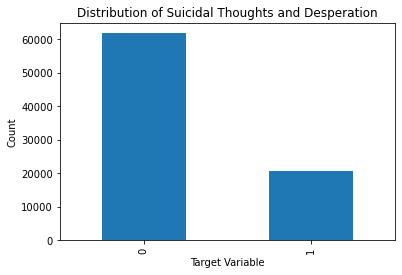

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Descriptive Analysis
target_counts = df['Suicidal Thoughts and Desperation'].value_counts()
print(target_counts)
target_counts.plot(kind='bar')
plt.title('Distribution of Suicidal Thoughts and Desperation')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()



In [65]:
# List of label column names
label_columns = ['Medication and Treatment', 'Discussion and Opinions', 'Greed and Corruption',
                 'Education and Career', 'Suicidal Thoughts and Desperation', 'Treatment and Recovery',
                 'Grief and Trauma', 'Inspiration and Positivity', 'Isolation and Reliability']

# Convert label values to 1 or 0 and cast as integer
df = df.astype(int)


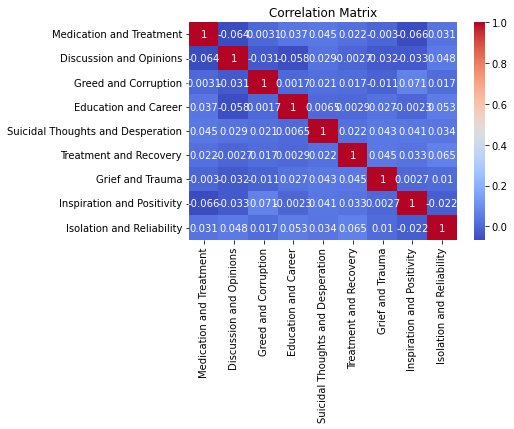

In [66]:
# Correlation Analysis
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()


In [67]:
# Logistic Regression
X = df.drop('Suicidal Thoughts and Desperation', axis=1)
y = df['Suicidal Thoughts and Desperation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.7495759631693725
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/home/jzhu10/.conda/envs/twitter/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#Step 6: Labeling the Posts and Factor Interpretation
# Assign the posts to the factor with the highest score
selected_df['factor_label'] = factor_scores.idxmax(axis=1)

# Merge the factor labels with the original dataframe
labeled_df = pd.concat([selected_df, factor_scores], axis=1)

/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# Identify the most influential keywords or loadings associated with each factor (you can also use Word2Vec similarity)
for factor in range(fa.n_components):
    factor_keywords = model.wv.similar_by_vector(fa.components_[factor], topn=10)
    print(f"Factor {factor+1} Keywords:")
    for keyword, similarity in factor_keywords:
        print(f"- {keyword}: {similarity}")
    print()



Factor 1 Keywords:
- 150mg: 0.6860669255256653
- 25mg: 0.6843504905700684
- pharmacyexcept: 0.6792904734611511
- max: 0.6777070760726929
- juli: 0.6768007278442383
- packet: 0.673913836479187
- 20mg: 0.6724658012390137
- 150: 0.6721847653388977
- rang: 0.6707371473312378
- mini: 0.6612363457679749

Factor 2 Keywords:
- grind: 0.6088122725486755
- wake: 0.6082404255867004
- awak: 0.5808974504470825
- afternoon: 0.5732017159461975
- sleep: 0.5683436989784241
- 6pm: 0.558655321598053
- 6am: 0.5506800413131714
- curl: 0.5503859519958496
- hemingway: 0.544493556022644
- sleepi: 0.5395972728729248

Factor 3 Keywords:
- greed: 0.7124307751655579
- corrupt: 0.6991637945175171
- cuán: 0.6882628798484802
- scum: 0.6791832447052002
- planet: 0.6716146469116211
- speci: 0.6676497459411621
- modern: 0.6630759835243225
- creatur: 0.6554188132286072
- wealth: 0.6554074883460999
- cog: 0.6533796787261963

Factor 4 Keywords:
- retir: 0.6087469458580017
- graduat: 0.5978100895881653
- marri: 0.573232352

In [71]:
df.head(3)

,Medication and Treatment,Discussion and Opinions,Greed and Corruption,Education and Career,Suicidal Thoughts and Desperation,Treatment and Recovery,Grief and Trauma,Inspiration and Positivity,Isolation and Reliability
0,0,1,0,1,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,1,1,1


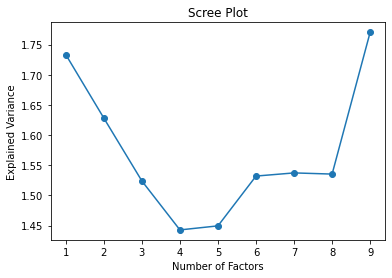

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis

# Convert the selected features to a numpy array
features = df
# Create an empty list to store the explained variances
explained_variances = []

# Perform factor analysis for different numbers of factors
for n_factors in range(1, 10):
    # Initialize the factor analysis model
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    
    # Fit the factor analysis model to the features
    fa.fit(features)
    
    # Append the explained variance to the list
    explained_variances.append(np.sum(fa.noise_variance_))
    
# Plot the scree plot
plt.plot(range(1, 10), explained_variances, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()


In [69]:
# Find the optimal number of factors based on the elbow of the scree plot
optimal_num_factors = np.argmax(np.diff(explained_variances)) + 1
print(f"The optimal number of factors is: {optimal_num_factors}")

The optimal number of factors is: 8


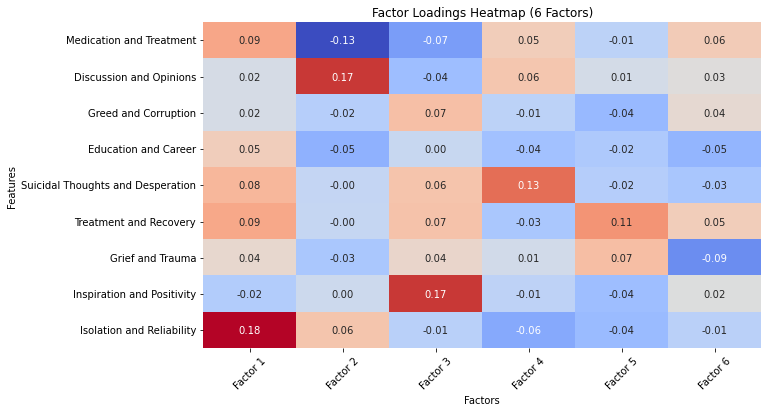

In [77]:

import seaborn as sns
import matplotlib.pyplot as plt
n_factors = 6 # Set the desired number of factors
fa = FactorAnalysis(n_components=n_factors, random_state=42)
fa.fit(df)
loadings_df = pd.DataFrame(fa.components_.T[:, :n_factors], columns=[f'Factor {i+1}' for i in range(n_factors)])
loadings_df.index = label_columns
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
plt.title(f'Factor Loadings Heatmap ({n_factors} Factors)')
plt.xlabel('Factors')
plt.ylabel('Features')
plt.xticks(rotation=45)
plt.show()

In [2]:

import pandas as pd
# Load the two datasets
df1 = pd.read_csv('Cleaned_overlappingusers_Dep1922.csv')
df2 = pd.read_csv('Cleaned_overlappingusers_Sui1922.csv')

In [4]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#Step 3: Train Word2Vec Model
from gensim.models import Word2Vec
selected_df  = df1


In [5]:
selected_df.head(3)

,Unnamed: 0,author,created_utc,selftext,title,subreddit,cleanedtext
0,0,MiniBoiiii,2019-04-01 00:38:19,i deal with depression and anxiety and hate ta...,school work import mental health,depression,deal depress anxieti hate talk mum sorri ameri...
1,1,PhoenixStorm1015,2019-04-01 01:27:48,this is gonna be a bit long. consider yourself...,say med bad idea,depression,go bit long consid warn amp take med noth peop...
2,2,SwixSwax,2019-04-01 01:42:20,sometimes i look back on my life and feel as i...,never love use,depression,sometim look back life feel never truli love l...


In [8]:
# Apply text preprocessing to the 'selftext' column
selected_df['preprocessed_text'] = selected_df['selftext'].apply(clean_text)

In [10]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#Step 3: Train Word2Vec Model
from gensim.models import Word2Vec
# Check for missing values and replace them with empty strings
selected_df['preprocessed_text'] = selected_df['preprocessed_text'].fillna('')

# Ensure all entries are strings
selected_df['preprocessed_text'] = selected_df['preprocessed_text'].astype(str)

# Tokenize the preprocessed text
tokenized_text = selected_df['preprocessed_text'].apply(word_tokenize)

# Tokenize the preprocessed text
tokenized_text = selected_df['preprocessed_text'].apply(word_tokenize)

In [11]:
# step 3 : Train the Word2Vec model
model = Word2Vec(tokenized_text, min_count=1)

In [12]:
#Step 4: Feature Extraction using Word Embeddings
import numpy as np

# Function to calculate the document embedding
def calculate_doc_embedding(text):
    embeddings = [model.wv[word] for word in word_tokenize(text) if word in model.wv]
    if embeddings:
        doc_embedding = np.mean(embeddings, axis=0)
        return doc_embedding
    return None

# Calculate document embeddings for the preprocessed text
selected_df['doc_embedding'] = selected_df['preprocessed_text'].apply(calculate_doc_embedding)

# Remove rows with missing document embeddings
selected_df = selected_df.dropna()


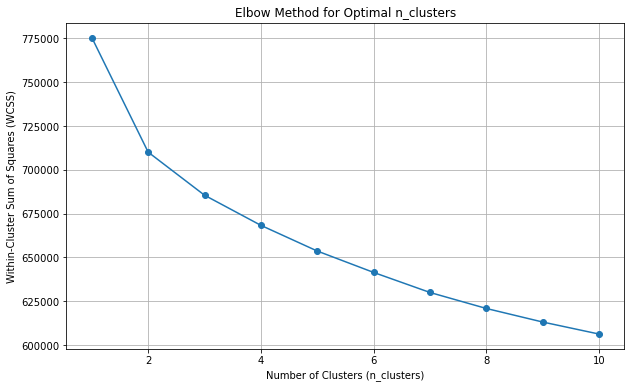

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract the document embeddings as features
features = np.array(selected_df['doc_embedding'].tolist())

# Define a range of values for n_clusters
n_clusters_range = range(1, 11)  # You can adjust the range as needed

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Calculate WCSS for different values of n_clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal n_clusters')
plt.grid()

# Identify the elbow point
# You can visually inspect the plot to find the point where the rate of decrease slows down
# In this case, it looks like n_clusters=5 might be a reasonable choice
plt.show()


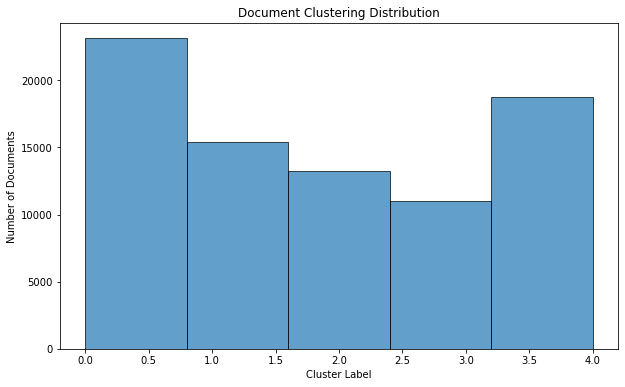

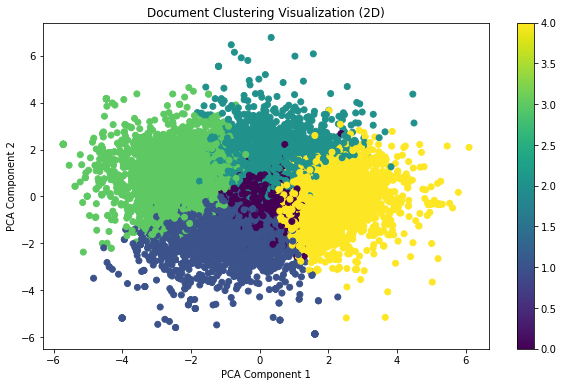

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract the document embeddings as features
features = np.array(selected_df['doc_embedding'].tolist())

# Choose the number of clusters (you can adjust this)
n_clusters = 5  # Adjust the number of clusters as needed

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features)

# Add cluster labels to the DataFrame
selected_df['cluster_label'] = kmeans.labels_

# Visualize the cluster distribution
plt.figure(figsize=(10, 6))
plt.hist(selected_df['cluster_label'], bins=n_clusters, edgecolor='k', alpha=0.7)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Documents')
plt.title('Document Clustering Distribution')
plt.show()

# Optionally, you can visualize the clusters in 2D (you may need dimensionality reduction)
# You can use techniques like PCA or t-SNE for dimensionality reduction

# For example, using PCA:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=selected_df['cluster_label'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Document Clustering Visualization (2D)')
plt.colorbar()
plt.show()


In [40]:
#Here's a step-by-step implementation of the factor analysis process, including the determination of the optimal number of factors:
from sklearn.decomposition import FactorAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert document embeddings to a numpy array
features = np.array(selected_df['doc_embedding'].tolist())

# Step 2: Determine the optimal number of factors
n_factors = range(1, 10)  # Specify the range of factor numbers to consider
explained_variances = []

for n in n_factors:
    fa = FactorAnalysis(n_components=n, random_state=42)
    fa.fit(features)
    noise_variance = np.mean(fa.noise_variance_)
    total_variance = np.sum(np.var(features, axis=0))
    explained_variance_ratio = 1 - (noise_variance / total_variance)
    explained_variances.append(explained_variance_ratio)

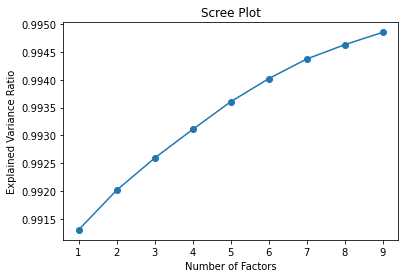

Optimal Number of Factors: 9


In [41]:
# Plot the scree plot to visualize explained variances
plt.plot(n_factors, explained_variances, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# Step 3: Choose the optimal number of factors based on the scree plot
optimal_n_factors = np.argmax(explained_variances) + 1
print(f"Optimal Number of Factors: {optimal_n_factors}")


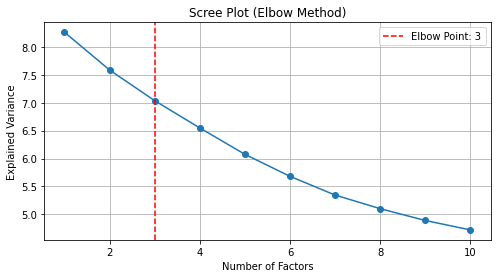

In [43]:
import numpy as np
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

# Extract the document embeddings as features
features = np.array(selected_df['doc_embedding'].tolist())

# Initialize the range of factors to explore
max_factors = 10  # Set a reasonable maximum number of factors to explore
explained_variances = []

# Fit the factor analysis model with different numbers of factors
for n_factors in range(1, max_factors + 1):
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(features)
    
    # Calculate the explained variance
    explained_variance = np.sum(fa.noise_variance_)
    explained_variances.append(explained_variance)

# Create a scree plot to visualize explained variances
plt.figure(figsize=(8, 4))
plt.plot(range(1, max_factors + 1), explained_variances, marker='o', linestyle='-')
plt.title('Scree Plot (Elbow Method)')
plt.xlabel('Number of Factors')
plt.ylabel('Explained Variance')
plt.grid()

# Manually identify the elbow point from the plot
elbow_point = 3  # Set the elbow point based on the plot
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.legend()

plt.show()


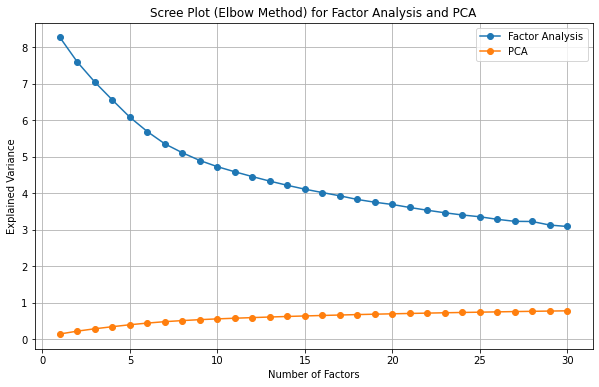

In [46]:
import numpy as np
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib.pyplot as plt

# Extract the document embeddings as features
features = np.array(selected_df['doc_embedding'].tolist())

# Initialize the range of factors to explore
max_factors = 30  # Set a reasonable maximum number of factors to explore
explained_variances_fa = []
explained_variances_pca = []

# Fit the factor analysis model with different numbers of factors
for n_factors in range(1, max_factors + 1):
    # Factor Analysis
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(features)
    
    # Calculate the explained variance for Factor Analysis
    explained_variance_fa = np.sum(fa.noise_variance_)
    explained_variances_fa.append(explained_variance_fa)

    # Principal Component Analysis (PCA)
    pca = PCA(n_components=n_factors, random_state=42)
    pca.fit(features)
    
    # Calculate the explained variance for PCA
    explained_variance_pca = np.sum(pca.explained_variance_ratio_)
    explained_variances_pca.append(explained_variance_pca)

# Create a scree plot to visualize explained variances
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_factors + 1), explained_variances_fa, marker='o', linestyle='-', label='Factor Analysis')
plt.plot(range(1, max_factors + 1), explained_variances_pca, marker='o', linestyle='-', label='PCA')
plt.title('Scree Plot (Elbow Method) for Factor Analysis and PCA')
plt.xlabel('Number of Factors')
plt.ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()


In [15]:
# Identify the most influential keywords or loadings associated with each factor (you can also use Word2Vec similarity)
for factor in range(fa.n_components):
    factor_keywords = model.wv.similar_by_vector(fa.components_[factor], topn=10)
    print(f"Factor {factor+1} Keywords:")
    for keyword, similarity in factor_keywords:
        print(f"- {keyword}: {similarity}")
    print()

Factor 1 Keywords:
- suspend: 0.7391149401664734
- bell: 0.6918361783027649
- antibiot: 0.6778570413589478
- detox: 0.6774976849555969
- capsul: 0.6707648634910583
- discharg: 0.6660698652267456
- packet: 0.6639246344566345
- twelv: 0.6587916612625122
- rang: 0.6581243872642517
- fiestera: 0.6579405665397644

Factor 2 Keywords:
- wake: 0.6069292426109314
- grind: 0.5981152653694153
- daymi: 0.570848822593689
- awak: 0.5661258697509766
- clock: 0.5651111006736755
- motion: 0.5489307641983032
- curl: 0.5347018241882324
- sleep: 0.5341978669166565
- foreveranyth: 0.5301703214645386
- dread: 0.528988242149353

Factor 3 Keywords:
- greed: 0.7273003458976746
- corrupt: 0.7058146595954895
- scum: 0.691470742225647
- creatur: 0.6844763159751892
- speci: 0.6842293739318848
- era: 0.6532224416732788
- racism: 0.6521527767181396
- breed: 0.6519607305526733
- ancestor: 0.6509400010108948
- winner: 0.6470301747322083

Factor 4 Keywords:
- dissoci: 0.7133981585502625
- sensat: 0.7066137790679932
- d

In [17]:
#Step 5: Factor Analysis
from sklearn.decomposition import FactorAnalysis

# Convert document embeddings to a numpy array
features = np.array(selected_df['doc_embedding'].tolist())

# Initialize the factor analysis model
fa = FactorAnalysis(n_components=9, random_state=42)

# Fit the factor analysis model to the features
fa.fit(features)

# Get the factor scores
factor_scores = pd.DataFrame(fa.transform(features), columns=['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7', 'Factor 8', 'Factor 9'])


In [18]:
for factor in range(factor_scores.shape[1]):
    selected_df[f'Factor_{factor+1}'] = np.where(factor_scores[f'Factor {factor+1}'] > 0.5, 1, 0)

/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jzhu10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [22]:
 selected_df.head(3)

,Unnamed: 0,author,created_utc,selftext,title,subreddit,cleanedtext,preprocessed_text,doc_embedding,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Factor_8,Factor_9
0,0,MiniBoiiii,2019-04-01 00:38:19,i deal with depression and anxiety and hate ta...,school work import mental health,depression,deal depress anxieti hate talk mum sorri ameri...,deal depress anxieti hate talk mum sorri ameri...,"[-0.06072321, -0.4892187, -0.1764966, -0.57299...",0,0,0,0,0,0,0,1,0
1,1,PhoenixStorm1015,2019-04-01 01:27:48,this is gonna be a bit long. consider yourself...,say med bad idea,depression,go bit long consid warn amp take med noth peop...,go bit long consid warn amp take med noth peop...,"[-0.0010210753, -0.43432865, -0.29277712, -0.7...",1,0,0,0,0,0,0,0,0
2,2,SwixSwax,2019-04-01 01:42:20,sometimes i look back on my life and feel as i...,never love use,depression,sometim look back life feel never truli love l...,sometim look back life feel never truli love l...,"[0.55333096, -0.23695092, -0.30665246, -0.2402...",0,0,1,0,0,0,1,0,0


In [19]:
factor_scores.head(3)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
0,0.446812,-0.733251,-0.428492,-0.320199,-0.125838,-0.487333,-0.772602,1.109100,-0.410954
1,1.015274,-0.273747,-0.374246,0.278919,-0.198904,0.486573,-0.075158,-0.125045,0.423156
2,-0.687513,-0.826741,0.846253,0.482024,-0.558018,-0.829163,1.075733,-0.685794,0.467204


In [29]:
factor_scores.shape

(81605, 9)

In [ ]:
# Create a heatmap for Factor 9
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Factor 9']], cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
plt.title('Factor 9 Heatmap')
plt.xlabel('Factors')
plt.ylabel('Samples')
plt.show()

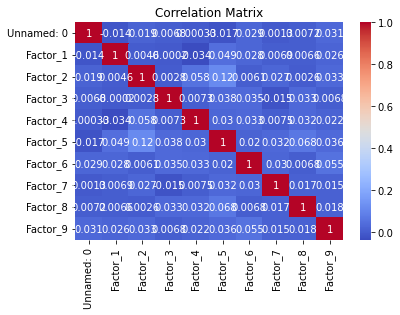

In [24]:

import seaborn as sns
import matplotlib.pyplot as plt# Correlation Analysis
corr_matrix =  selected_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()


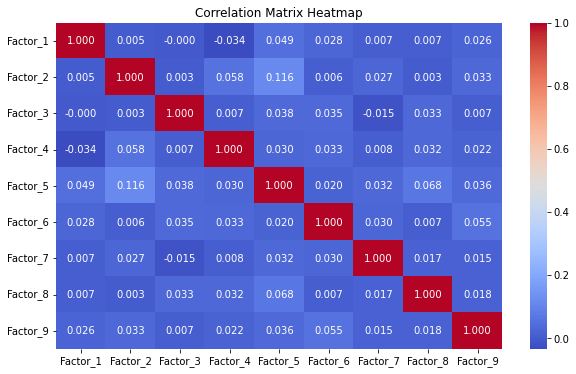

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt
selected_df = selected_df.drop(columns=['Unnamed: 0'])

# Correlation Analysis
corr_matrix = selected_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()


In [34]:
# Get the factor loading matrix
factor_loadings_matrix = pd.DataFrame(factor_scores, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Factor 6', 'Factor 7', 'Factor 8', 'Factor 9'])

# Print or use the factor loadings matrix
print(factor_loadings_matrix)


       Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  \
0      0.446812 -0.733251 -0.428492 -0.320199 -0.125838 -0.487333 -0.772602   
1      1.015274 -0.273747 -0.374246  0.278919 -0.198904  0.486573 -0.075158   
2     -0.687513 -0.826741  0.846253  0.482024 -0.558018 -0.829163  1.075733   
3      0.086336  2.359686 -1.671213  0.445743 -0.360602 -0.700723 -0.426381   
4      0.258197 -0.469316  1.051396  0.617712 -0.345518 -0.505457  0.315722   
...         ...       ...       ...       ...       ...       ...       ...   
81600 -0.121570 -1.025469  0.759832  0.406389 -1.680873 -1.188765  0.197581   
81601  0.178943 -1.213479  0.145553  0.214776 -0.158367 -0.681116 -0.080350   
81602  1.589861  1.230387  0.138404  0.504875  0.281327  0.216112 -1.134189   
81603 -0.423734  0.076522 -0.547873 -0.430772 -0.366115 -0.567599 -0.490346   
81604  1.094090  0.139027  0.328882  0.730383  0.362419  0.376763 -0.139403   

       Factor 8  Factor 9  
0      1.109100 -0.4109

In [51]:
#Step 5: Factor Analysis
from sklearn.decomposition import FactorAnalysis

# Convert document embeddings to a numpy array
features = np.array(selected_df['doc_embedding'].tolist())

# Initialize the factor analysis model
fa = FactorAnalysis(n_components=6, random_state=42)

# Fit the factor analysis model to the features
fa.fit(features)

# Get the factor scores
#factor_scores = pd.DataFrame(fa.transform(features), columns=['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7', 'Factor 8', 'Factor 9'])


FactorAnalysis(n_components=6, random_state=42)

In [52]:
# Identify the most influential keywords or loadings associated with each factor (you can also use Word2Vec similarity)
for factor in range(fa.n_components):
    factor_keywords = model.wv.similar_by_vector(fa.components_[factor], topn=6)
    print(f"Factor {factor+1} Keywords:")
    for keyword, similarity in factor_keywords:
        print(f"- {keyword}: {similarity}")
    print()

Factor 1 Keywords:
- suspend: 0.7382442355155945
- bell: 0.6905873417854309
- antibiot: 0.6807220578193665
- detox: 0.6792498230934143
- capsul: 0.6713626384735107
- discharg: 0.668621838092804

Factor 2 Keywords:
- wake: 0.6277772784233093
- awak: 0.5839582085609436
- grind: 0.5765010714530945
- sleep: 0.5648623108863831
- daymi: 0.5642204880714417
- clock: 0.5531495213508606

Factor 3 Keywords:
- greed: 0.7257519364356995
- corrupt: 0.6947771310806274
- scum: 0.6900882720947266
- creatur: 0.6660944223403931
- speci: 0.6577173471450806
- fastidioso: 0.6545231938362122

Factor 4 Keywords:
- dissoci: 0.7184284925460815
- sensat: 0.6953645348548889
- disassoci: 0.6921404600143433
- apathi: 0.6297210454940796
- anhedonia: 0.6244664788246155
- dizzi: 0.6100914478302002

Factor 5 Keywords:
- pls: 0.6432754993438721
- plead: 0.622651219367981
- ear: 0.6031296849250793
- plz: 0.5716747045516968
- goodnight: 0.5610441565513611
- beg: 0.5490063428878784

Factor 6 Keywords:
- resist: 0.614498913

In [53]:
# Get the factor scores
factor_scores = pd.DataFrame(fa.transform(features), columns=['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6'])

In [54]:
factor_scores.shape

(81605, 6)

In [55]:
selected_df.shape

(81605, 18)

In [56]:
# Concatenate factor_scores with selected_df
selected_df = pd.concat([selected_df, factor_scores], axis=1)